<a href="https://colab.research.google.com/github/berkyyd/Projects/blob/main/flo_uyg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
import veri_bilimi as vb

In [2]:
def load():
  df = pd.read_csv('flo_data_20k.csv')
  return df
df = load()

In [3]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [4]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains('date')]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [6]:
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (df["last_order_date"] - df["first_order_date"]).dt.days

In [7]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],95,119
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105,1469
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",186,366
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",135,11
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],86,582


In [8]:
model_df = df[["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]

Kümeleme

In [9]:
def check_skew(df_skew, column):
  skew = stats.skew(df_skew[column])
  skewtest = stats.skewtest(df_skew[column])
  plt.title('Distribution of ' + column)
  sns.distplot(df_skew[column], color = 'g')
  print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


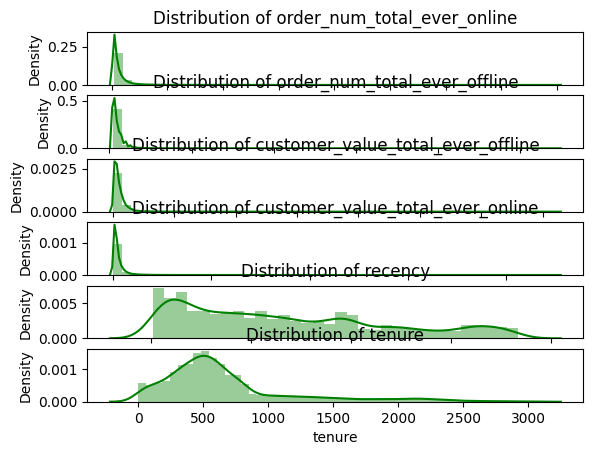

In [10]:
plt.subplot(6, 1, 1)
check_skew(model_df, "order_num_total_ever_online")
plt.subplot(6, 1, 2)
check_skew(model_df, "order_num_total_ever_offline")
plt.subplot(6, 1, 3)
check_skew(model_df, "customer_value_total_ever_offline")
plt.subplot(6, 1, 4)
check_skew(model_df, "customer_value_total_ever_online")
plt.subplot(6, 1, 5)
check_skew(model_df, "recency")
plt.subplot(6, 1, 6)
check_skew(model_df, "tenure")
plt.tight_layout()
plt.savefig('skew.png', format='png', dpi=1000)
plt.show()

# çarpıklık var mı yok mu görsel olarak bakıyoruz

In [11]:
# normal dağılım için log transformation uygulaması
model_df["order_num_total_ever_online"] = np.log1p(model_df["order_num_total_ever_online"])
model_df["order_num_total_ever_offline"] = np.log1p(model_df["order_num_total_ever_offline"])
model_df["customer_value_total_ever_offline"] = np.log1p(model_df["customer_value_total_ever_offline"])
model_df["customer_value_total_ever_online"] = np.log1p(model_df["customer_value_total_ever_online"])
model_df["recency"] = np.log1p(model_df["recency"])
model_df["tenure"] = np.log1p(model_df["tenure"])
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.609438,0.693147,4.948689,6.685087,4.564348,4.787492
1,2.995732,1.098612,5.081218,7.525414,4.663439,7.293018
2,1.386294,1.098612,5.252116,5.982298,5.231109,5.905362
3,0.693147,0.693147,3.713328,4.418600,4.912655,2.484907
4,0.693147,0.693147,3.931630,5.081342,4.465908,6.368187


In [12]:
# scaling işlemleri
sc = MinMaxScaler((0,1))
model_scaling = sc.fit_transform(model_df)
model_df = pd.DataFrame(model_scaling, columns = model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.597095
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.909584
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.736516
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.309917
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.794240


Optimum Küme Sayısı

In [13]:
from yellowbrick.cluster import KElbowVisualizer

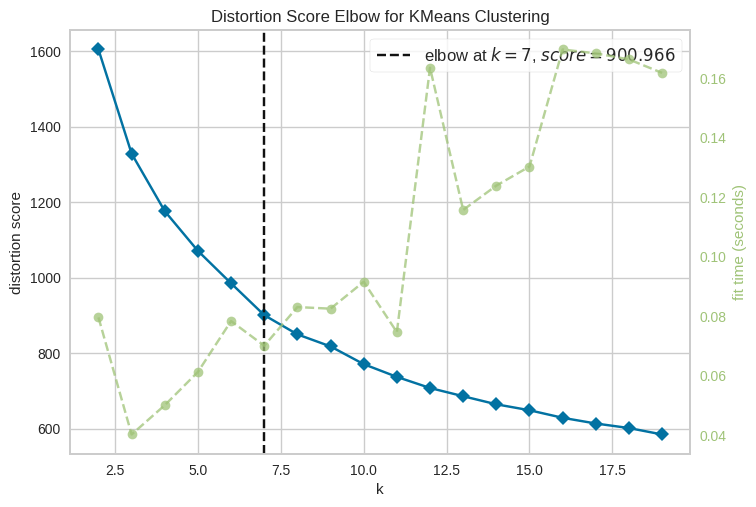

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(model_df)
elbow.show() # 7

Model

In [15]:
k_means = KMeans(n_clusters=7, random_state=42).fit(model_df)
segments = k_means.labels_

final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0,1.0,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0,2.0,159.97,1853.58,105,1469,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0,2.0,189.97,395.35,186,366,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0,1.0,39.99,81.98,135,11,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0,1.0,49.99,159.99,86,582,2


Her Bir Segmenti İnceleme

In [17]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                 "order_num_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_online":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})



order_num_total_ever_online              ... tenure            
                               mean  min    max  ...    min   max count
segment                                          ...                   
0                          1.429881  1.0    5.0  ...     52  2820  5455
1                          1.404358  1.0    8.0  ...      0   132   826
2                          1.610099  1.0    6.0  ...     51  2828  3347
3                          6.459710  1.0   55.0  ...     26  2964  3239
4                          2.153468  1.0   11.0  ...      2  2962  1831
5                          1.825107  1.0   13.0  ...     20  2911  3282
6                          8.570483  2.0  200.0  ...     18  3034  1965

[7 rows x 19 columns]

Hiyerarşik Kümeleme İle Müşteri Segmenti

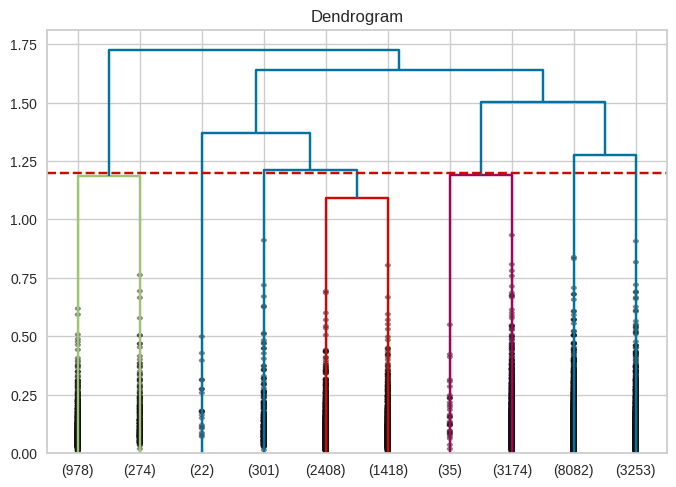

In [18]:
hc_complete = linkage(model_df, "complete")
plt.title("Dendrogram")
dend = dendrogram(hc_complete,
                  truncate_mode="lastp",
                  p=10,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

Model

In [19]:
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0,1.0,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0,2.0,159.97,1853.58,105,1469,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0,2.0,189.97,395.35,186,366,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0,1.0,39.99,81.98,135,11,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0,1.0,49.99,159.99,86,582,0


In [20]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                 "order_num_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_offline":["mean","min","max"],
                                 "customer_value_total_ever_online":["mean","min","max"],
                                 "recency":["mean","min","max"],
                                 "tenure":["mean","min","max","count"]})

order_num_total_ever_online              ... tenure            
                               mean  min    max  ...    min   max count
segment                                          ...                   
0                          1.371099  1.0   13.0  ...      3  2911  8747
1                          3.753905  1.0   49.0  ...     18  3034  4994
2                          6.905676  1.0  200.0  ...    109  3016  2396
3                          1.396954  1.0    6.0  ...      0   555   985
4                          4.741056  1.0   24.0  ...     71  2964  2823

[5 rows x 19 columns]